# PPO agent 학습용 scratch codes

In [4]:
import numpy as np
import os
os.environ['MKL_SERVICE_FORCE_INTEL'] = '1'
import torch
import pandas as pd

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.utils import get_schedule_fn

import gymnasium as gym
from stable_baselines3.common.utils import set_random_seed

import const
from env import MarketEnv

from typing import List, Dict, Callable

In [5]:
def make_env(market_df: pd.DataFrame, 
             asset_definition: dict, 
             initial_cash: float, 
             lookback_T: int, 
             sharpe_eta: float,
             deterministic: bool = False, 
             debug: bool = False) -> Callable[[], gym.Env]:
    """
    SubprocVecEnv 사용을 위해 환경을 생성하는 함수
    """
    def _init():
        env = MarketEnv(
            lookback_T=lookback_T,
            sharpe_eta=sharpe_eta,
            asset_definition=asset_definition,
            market_df=market_df,
            initial_cash=initial_cash,
            deterministic=deterministic,
            debug=debug
        )
        return env
    return _init

def get_ranged_schedule_fn(lr_range):
    start_lr, end_lr = lr_range
    def lr_schedule(progress_remaining):
        return end_lr + (start_lr - end_lr) * progress_remaining
    return lr_schedule

def fold_data_load(root_dir: str):
    dataset_list: List[Dict[str, pd.DataFrame]] = []
    
    folds = os.listdir(root_dir)

    for fold in folds:
        fold_path = os.path.join(root_dir, fold)
        dataset = {}
        for data_type in const.SPLIT:
            data = pd.read_csv(os.path.join(fold_path, f"{data_type}_processed.csv"))
            dataset[data_type] = data
        dataset_list.append(dataset)
    
    return dataset_list  

In [6]:
data_root = "./data/processed"
data_list = fold_data_load(data_root)

n_envs = 10
n_steps = 252 * 3 * n_envs  # rollout buffer size
total_timesteps = n_steps
SEEDS = [1000, 2000, 3000, 4000, 5000]

ppo_hyperparams = const.PPOEnvConst()
data_definition = const.AssetConst()

for idx, each_fold in enumerate(data_list):
    
    train_data = each_fold["train"]
    valid_data = each_fold["val"]
    test_data = each_fold["test"]

    # 초기 정책 로딩 (이전 윈도우에서 잘된 정책, 첫 윈도우는 랜덤)
    # policy_path = f"ppo_policy_{start_year-1}.zip" # 이전 윈도우에서 잘 된 정책 경로
    # 만약 첫 윈도우이면 policy_path가 없을 수도 있음, 이 경우 None
    # seed agents를 위한 loop
    best_validation_reward = -np.inf
    best_agent_path = None

    for seed in SEEDS:
        # 병렬 환경 생성 (학습용)
        def train_env_factory():
            return make_env(
                market_df=train_data,
                asset_definition=data_definition.SNP_INDICES_ASSETS,
                initial_cash=data_definition.initial_cash,
                lookback_T=data_definition.LOOKBACK_T,
                sharpe_eta=data_definition.SHARPE_ETA,
                deterministic=False,
                debug=False
            )
        
        train_env = SubprocVecEnv([train_env_factory() for _ in range(n_envs)])

        # validation 환경 (evaluation용)
        def val_env_factory():
            return make_env(
                market_df=valid_data,
                asset_definition=data_definition.SNP_INDICES_ASSETS,
                initial_cash=data_definition.initial_cash,
                lookback_T=data_definition.LOOKBACK_T,
                sharpe_eta=data_definition.SHARPE_ETA,
                deterministic=True,
                debug=False
            )
            
        val_env = make_env(
            market_df=valid_data,
            asset_definition=data_definition.SNP_INDICES_ASSETS,
            initial_cash=data_definition.initial_cash,
            lookback_T=data_definition.LOOKBACK_T,
            sharpe_eta=data_definition.SHARPE_ETA,
            deterministic=True,
            debug=False
        )()

        # EvalCallback 설정
        eval_callback = EvalCallback(
            val_env,
            best_model_save_path='./logs/',
            log_path='./logs/',
            eval_freq=n_steps,  # 주기적으로 validation 평가
            deterministic=True,
            render=False
        )

        # 이전 윈도우의 best agent를 초기 파라미터로 로드할지 여부
        # 여기서는 예시로 이전 window best_agent_path가 있다면 로드
        if best_agent_path is not None:
            model = PPO.load(
                best_agent_path,
                env=train_env,
                device='auto'
            )
            model.set_parameters(model.get_parameters())  # 현재 PPO에 파라미터 셋팅
        else:
            # 처음 윈도우면 새로운 PPO
            model = PPO(
                "MlpPolicy",
                train_env,
                n_steps=n_steps,
                batch_size=ppo_hyperparams.BATCH_SIZE,
                n_epochs=ppo_hyperparams.N_EPOCHS,
                gamma=ppo_hyperparams.GAMMA,
                gae_lambda=ppo_hyperparams.GAE_LAMBDA,
                clip_range=ppo_hyperparams.CLIP_RANGE,
                learning_rate=get_ranged_schedule_fn((ppo_hyperparams.LEARNING_RATE_START, ppo_hyperparams.LEARNING_RATE_END)),
                policy_kwargs=ppo_hyperparams.PPOArch,
                verbose=1,
                seed=seed,
                tensorboard_log="./ppo_tensorboard/"
            )
        
        # 학습 진행
        model.learn(
            total_timesteps=total_timesteps,
            callback=eval_callback
        )

        # validation 평가 후 best model 확인
        # EvalCallback이 best_model을 ./logs/best_model.zip에 저장했을 것이므로
        # 여기서 validation 성능 확인 가능 (로그파일 분석 또는 callback 개선)
        # 간단히 여기서는 eval_callback에서 나온 best_mean_reward 비교
        # 실무에서는 eval_callback을 커스텀하거나, 저장된 모델로 다시 평가하여 reward를 계산한 뒤 비교
        
        # 예: best_model.zip 로드 후 validation 평가
        val_model = PPO.load("./logs/best_model.zip")
        # validation 평가
        # 간단히 rollout해서 평균 reward 계산 예시
        val_episodes = 10
        episode_rewards = []
        for _ in range(val_episodes):
            obs, info = val_env.reset()
            done = False
            total_rew = 0
            while True:
                action, _states = val_model.predict(obs, deterministic=True)
                obs, rew, terminated, truncated, info = val_env.step(action)
                total_rew += rew
                if terminated or truncated:
                    break
            episode_rewards.append(total_rew)
        mean_val_reward = np.mean(episode_rewards)

        if mean_val_reward > best_validation_reward:
            best_validation_reward = mean_val_reward
            best_agent_path = f"./logs/best_window_{idx}_{seed}.zip"
            val_model.save(best_agent_path)

        train_env.close()
        del train_env
        val_env.close()
        del val_env

    # best_agent_path 가 현재 윈도우의 best policy
    # 다음 윈도우 학습시 초기값으로 이용 가능
    # 테스트 데이터로 backtest 수행도 가능
    test_env = make_env(
        market_df=test_data,
        asset_definition=data_definition.SNP_INDICES_ASSETS,
        initial_cash=data_definition.initial_cash,
        lookback_T=data_definition.LOOKBACK_T,
        sharpe_eta=data_definition.SHARPE_ETA,
        deterministic=True,
        debug=False
    )()

    best_model = PPO.load(best_agent_path)
    obs, info = test_env.reset()
    done = False
    test_rewards = []
    while True:
        action, _states = best_model.predict(obs, deterministic=True)
        obs, rew, terminated, truncated, info = test_env.step(action)
        test_rewards.append(rew)
        if terminated or truncated:
            break

    mean_test_reward = np.mean(test_rewards)
    print(f"Window {idx}, Best validation reward: {best_validation_reward}, Test reward: {mean_test_reward}")
    test_env.close()

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading 

Using cuda device


/home/david3684/.local/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


ImportError: Trying to log data to tensorboard but tensorboard is not installed.

In [21]:
data_root = "./data/processed"
data_list = fold_data_load(data_root)
test_data = data_list[0]["train"]
best_agent_path = "/data2/code/2024_DS801/logs/best_model.zip"

ppo_hyperparams = const.PPOEnvConst()
data_definition = const.AssetConst()

test_env = make_env(
            market_df=test_data,
            asset_definition=data_definition.SNP_INDICES_ASSETS,
            initial_cash=data_definition.initial_cash,
            lookback_T=data_definition.LOOKBACK_T,
            sharpe_eta=data_definition.SHARPE_ETA,
            deterministic=True,
            debug=False
        )()

best_model = PPO.load(best_agent_path)
obs, info = test_env.reset()
done = False
test_rewards = []
while True:
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rew, terminated, truncated, info = test_env.step(action)
    test_rewards.append(rew)
    if terminated or truncated:
        break

/home/david3684/.local/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [22]:
data = test_env.portfolio_ac[data_definition.LOOKBACK_T:].sum(axis=1)

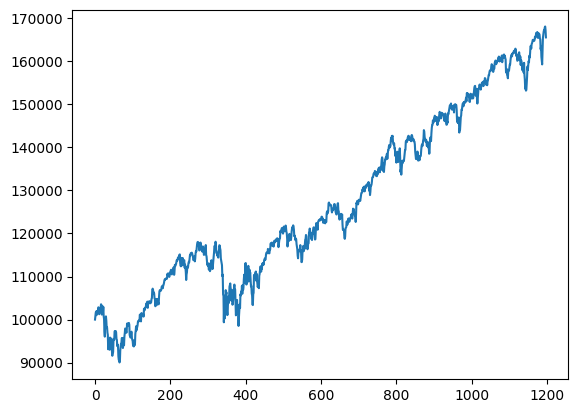

In [23]:
import matplotlib.pyplot as plt

plt.plot(data)